In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

d      = 500
k      = 5
C, D   = k ** (-1/4) * torch.randn(2, d, k, device=device)
A_star = C @ D.T
E      = torch.randn(d, d, device=device)

In [19]:
def run(gamma_sigma_sq, gamma_w):
    w        = d ** gamma_w
    sigma_sq = d ** gamma_sigma_sq
    
    if gamma_w + gamma_sigma_sq > 1:
        eta = 1 / (5 * w * sigma_sq)
    else:
        eta = 1 / (5 * torch.linalg.norm(A_star, ord=2).cpu())

    w  = int(w)
    W1 = sigma_sq ** (1/2) * torch.randn(w, d, device=device)
    W2 = sigma_sq ** (1/2) * torch.randn(d, w, device=device)
    B  = W2 @ W1

    losses_gd, losses_approx, gen_losses_gd, gen_losses_ap, svs_gd, svs_ap = [], [], [], [], [], []
    
    svs_gd.append(torch.svd(W2 @ W1, compute_uv=False)[1].cpu().numpy())
    svs_ap.append(torch.svd(B, compute_uv=False)[1].cpu().numpy())
    
    for i in range(100):
        # GD dynamics
        A  = W2 @ W1        
        W1 = W1 - eta * W2.T @ (A - (A_star + E))
        W2 = W2 - eta * (A - (A_star + E)) @ W1.T

        # Approx. dynamics
        U, S, VT = torch.linalg.svd(B @ B.T + (sigma_sq * w) ** 2 * torch.eye(d, d, device=device))
        Up, Sp, VTp = torch.linalg.svd(B.T @ B + (sigma_sq * w) ** 2 * torch.eye(d, d, device=device))
        S, Sp = torch.diag(S), torch.diag(Sp)
        G = B - (A_star + E)
        B = B - eta * ((U @ torch.sqrt(S) @ VT) @ G + G @ (Up @ torch.sqrt(Sp) @ VTp)) 

        # Losses
        loss_gd     = (torch.norm(W2 @ W1 - (A_star + E)) ** 2 / d ** 2).cpu().numpy()
        loss_approx = (torch.norm(B - (A_star + E)) ** 2 / d ** 2).cpu().numpy()
        gen_loss_gd = (torch.norm(W2 @ W1 - A_star) ** 2 / d ** 2).cpu().numpy()
        gen_loss_ap = (torch.norm(B - A_star) ** 2 / d ** 2).cpu().numpy()
        
        losses_gd.append(loss_gd)
        losses_approx.append(loss_approx)
        gen_losses_gd.append(gen_loss_gd)
        gen_losses_ap.append(gen_loss_ap)
        svs_gd.append(torch.svd(W2 @ W1, compute_uv=False)[1].cpu().numpy())
        svs_ap.append(torch.svd(B, compute_uv=False)[1].cpu().numpy())

        if i % 50 == 0: print(i, loss_gd, loss_approx, gen_loss_gd, gen_loss_ap)
        
    return losses_gd, losses_approx, gen_losses_gd, gen_losses_ap, svs_gd, svs_ap

In [42]:
gamma_sigma_sq, gamma_w = -1.85, 2.25
data = run(gamma_sigma_sq, gamma_w)

0 1.896943 1.8976344 0.9428894 0.94357055 2.965589e-07
50 0.043303147 0.044469714 0.64824766 0.64285684 2.5781828e-05


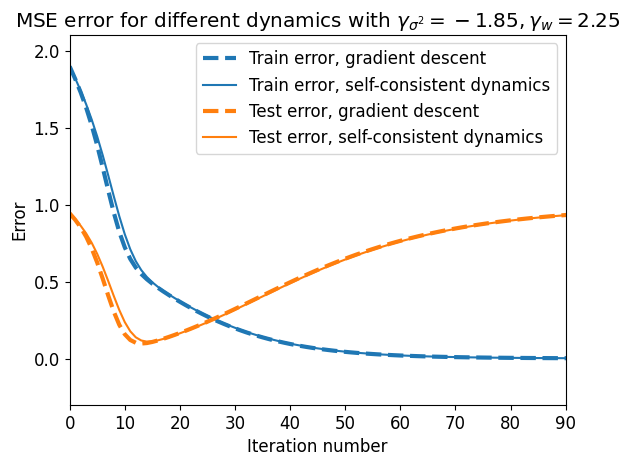

In [75]:
plt.title('MSE error for different dynamics with $\gamma_{\sigma^2} = -1.85, \gamma_w = 2.25$')
plt.plot(data[0], '--', label='Train error, gradient descent',lw=3, c='#1f77b4')
plt.plot(data[1], label='Train error, self-consistent dynamics', c='#1f77b4')

plt.plot(data[2], '--', label='Test error, gradient descent', lw=3, c='#ff7f0e')
plt.plot(data[3], label='Test error, self-consistent dynamics', c='#ff7f0e')
plt.ylim(-.3, 2.1)
plt.xlim(0, 90)
plt.legend()

plt.ylabel('Error')
plt.xlabel('Iteration number')
plt.savefig('error.png')

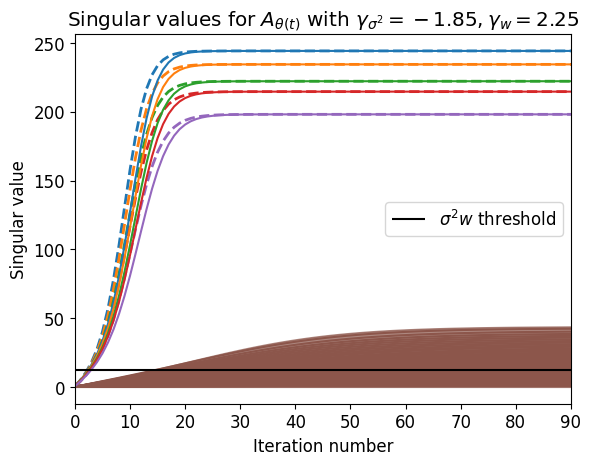

In [78]:
lim = 90
gd = np.array(data[4])
ap = np.array(data[5])
cs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i in range(5):
    plt.plot(gd[:, i], '--', lw=2, c=cs[i])
    
plt.fill_between(np.arange(100+1), gd[:, 5], gd[:, -1], color='#8c564b', alpha=0.7)
a = [10 * n for n in np.arange(1, 50)]
plt.plot(gd[:, a], c='#8c564b')

for i in range(5):
    plt.plot(ap[:, i], c=cs[i])

plt.title(r'Singular values for $A_{\theta(t)}$ with $\gamma_{\sigma^2} = -1.85, \gamma_w = 2.25$')

plt.hlines(d ** (gamma_sigma_sq + gamma_w), 0, lim, label='$\sigma^2 w$ threshold', color='black')
plt.ylabel('Singular value')
plt.xlabel('Iteration number')
plt.legend()

plt.xlim(0,lim)

plt.savefig('active.png')